In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from dotenv import load_dotenv
import os
from stock_predictor.data_loader import fetch_alpha_vantage
from stock_predictor.training_pipeline import split_data, scale_data, prepare_sequences
from stock_predictor.model_building import build_and_train_model, predict_and_inverse


2025-05-06 16:59:33.645391: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-06 16:59:33.663630: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-06 16:59:33.927722: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-06 16:59:34.201395: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746543574.358106   45372 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746543574.39

In [3]:

# In deinem Python-Skript:
from dotenv import load_dotenv
import os

load_dotenv()
api_key = os.getenv("ALPHAVANTAGE_API_KEY_1")

print(api_key)

9M2NC2CCUWDC2JRZ


In [4]:
# Daten abrufen mit eigener Funktion
from stock_predictor.data_loader import fetch_alpha_vantage

symbol = "IBM"

df_stock = fetch_alpha_vantage(symbol, api_key)

# Ergebnisse Anzeigen
df_stock.tail()


,open,high,low,close,volume
2025-04-29,237.000,239.98,236.1400,239.39,3426508.0
2025-04-30,236.730,242.47,234.3401,241.82,5142993.0
2025-05-01,241.440,242.37,237.9450,239.66,4243294.0
2025-05-02,243.125,245.69,241.3300,245.55,3731946.0
2025-05-05,243.740,249.80,243.6400,249.18,4138168.0


In [5]:
from stock_predictor.training_pipeline import split_data
# Daten in Trainingdaten und Testdaten aufteilen
train_df, test_df = split_data(df_stock, train_ratio=0.8)


In [6]:
import joblib
from stock_predictor.training_pipeline import scale_data

train_scaled, test_scaled, scaler = scale_data(train_df, test_df)

#scaler = joblib.load("models/scaler_ibm.pkl")


In [7]:
from stock_predictor.training_pipeline import prepare_sequences
# 3. Sequenzen erstellen (für LSTM)
X_train, y_train, X_test, y_test = prepare_sequences(train_scaled, test_scaled, target_col_index=3, n_steps=60)

In [8]:
from stock_predictor.model_building import build_and_train_model

# 4. Model bauen und Training
model = build_and_train_model(X_train, y_train)

W0000 00:00:1746543582.830817   45372 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 0.0400 - val_loss: 9.7677e-04
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 5.1899e-04 - val_loss: 9.0391e-04
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 4.8432e-04 - val_loss: 7.4844e-04
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 4.2130e-04 - val_loss: 7.3253e-04
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4.0419e-04 - val_loss: 6.6532e-04
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.8104e-04 - val_loss: 6.5862e-04
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.9665e-04 - val_loss: 5.7448e-04
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 3.2662e-04 - val_loss: 4.9360e-04
Epoch 9/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.4779e-04 - val_loss: 4.5414e-04
Epoch 10/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.1909e-04 - val_loss: 4.2122e-04


In [9]:
# Nach dem Training:
symbol = "IBM"
model.save(f"../models/lstm_{symbol.lower()}.keras")


In [10]:
# 5. Vorhersage + Rescaling zurück

from stock_predictor.model_building import predict_and_inverse


pred_rescaled, true_rescaled = predict_and_inverse(model, X_test, y_test, scaler, train_scaled.shape[1], target_col_index=3)


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


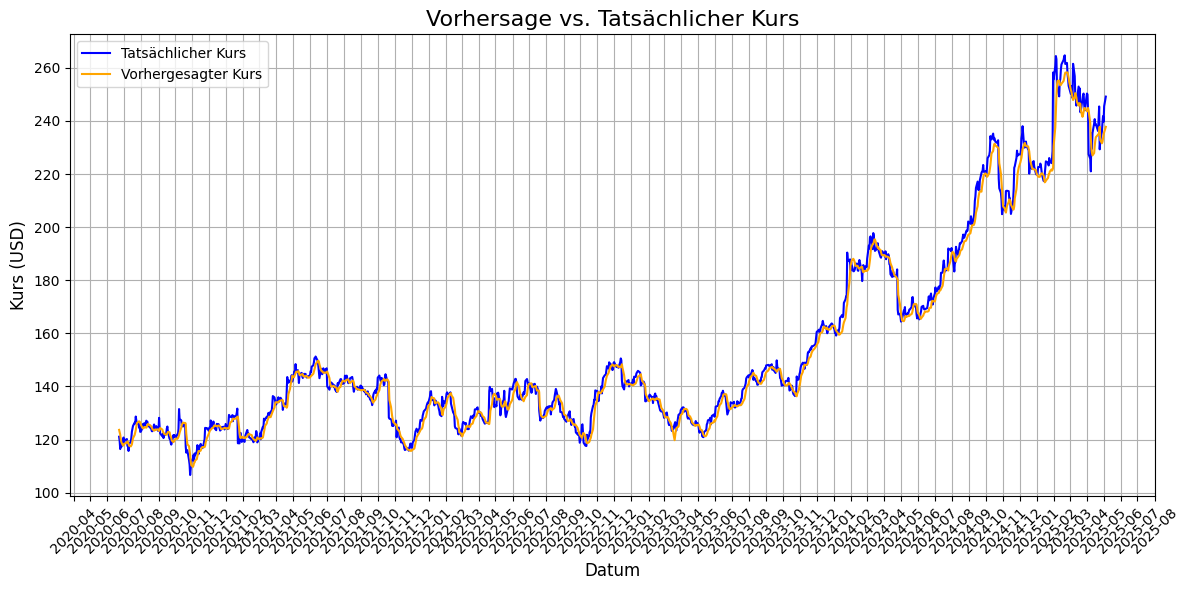

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# 6. Visualisierung (Streamlit / Matplotlib)

# Angenommen: du hast
# - pred_rescaled (Vorhersage)
# - true_rescaled (Tatsächlicher close-Preis)
# - test_df.index (Datumsindex vom Original-DataFrame)

fig, ax = plt.subplots(figsize=(12, 6))

# X-Achse sind die Zeitstempel aus dem Test-DataFrame
dates = test_df.index[-len(pred_rescaled):]

ax.plot(dates, true_rescaled, label='Tatsächlicher Kurs', color='blue')
ax.plot(dates, pred_rescaled, label='Vorhergesagter Kurs', color='orange')

# X-Achse mit Monat & Jahr
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Achsentitel & Formatierung
ax.set_title('Vorhersage vs. Tatsächlicher Kurs', fontsize=16)
ax.set_xlabel('Datum', fontsize=12)
ax.set_ylabel('Kurs (USD)', fontsize=12)
ax.grid(True)
ax.legend()

# Auto-Rotation für Datum
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Vergleich basiert auf den zurückskalierten Werten (echte vs. predicted)
rmse = np.sqrt(mean_squared_error(true_rescaled, pred_rescaled))
mae = mean_absolute_error(true_rescaled, pred_rescaled)
r2 = r2_score(true_rescaled, pred_rescaled)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.2f}")


RMSE: 3.80
MAE: 2.60
R² Score: 0.99


/tmp/ipykernel_45372/3599368792.py:25: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sa_linux/.pyenv/versions/3.10.6/envs/stock_predictor_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


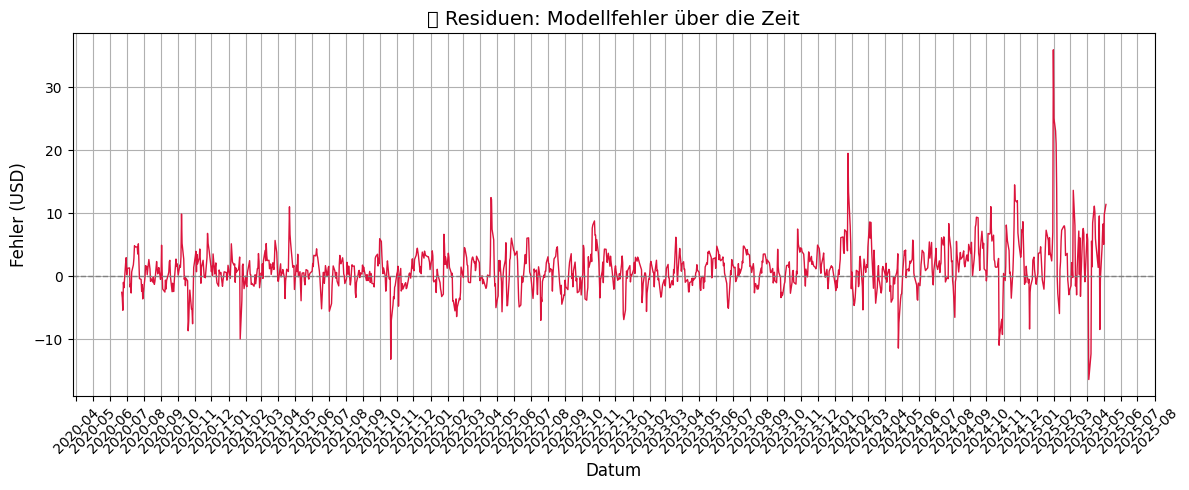

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# residuals = true_rescaled - pred_rescaled
# Annahme: test_df.index ist der Zeitindex der echten Daten
residuals = true_rescaled - pred_rescaled
residual_dates = test_df.index[-len(residuals):]

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(residual_dates, residuals, color='crimson', linewidth=1)
ax.axhline(0, linestyle='--', color='gray', linewidth=1)

# X-Achse: Monate mit Jahr anzeigen
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Beschriftungen & Format
ax.set_title("📉 Residuen: Modellfehler über die Zeit", fontsize=14)
ax.set_xlabel("Datum", fontsize=12)
ax.set_ylabel("Fehler (USD)", fontsize=12)
ax.grid(True)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
